# Fund Replication

### Libraries

In [1]:
from scipy.optimize import minimize
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm

## Optimizer

In [2]:
def weight_optimization(X, y, loss='mse', optimizer='SLSQP', long_only_contraint=True, leverage_contraint=True):
    
    # Initial Weights
    coeffs = np.full(X.shape[1], 1/X.shape[1])

    # Loss Function
    def loss_function(coeffs, X, y, loss):
        y_pred = X.dot(coeffs)
        if loss == 'mse':
            return np.mean((y - y_pred) ** 2)
        elif loss == 'mae':
            return np.mean(np.abs(y - y_pred))
        elif loss == 'te':
            return np.sqrt(np.sum((y - y_pred) ** 2) / (len(y) - 1))    

    # Constraints
    constraints = []

    # Long-Only Constraints
    if long_only_contraint:
        long_only_constraints = [{'type': 'ineq', 'fun': lambda coeffs, i=i: coeffs[i]} for i in range(X.shape[1])]
        constraints.extend(long_only_constraints)

    # Leverage Constraints
    if leverage_contraint:
        leverage_constraints = [{'type': 'ineq', 'fun': lambda coeffs: 1 - np.sum(coeffs)},
                                {'type': 'ineq', 'fun': lambda coeffs: np.sum(coeffs)}]
        constraints.extend(leverage_constraints)

    # Optimization
    result = minimize(loss_function, coeffs, args=(X, y, loss), method=optimizer, constraints=constraints, options={'ftol': 1e-9, 'disp': True})

    if result.success:
        return result.x
    else:
        raise ValueError("Optimization failed to converge")

## Aplication

In [3]:
# Securities

assets = ['SPYI.DE', 'XDEV.DE', 'IUSN.DE', 'XDEM.DE', 'XDEQ.DE', 'XDEB.DE', 'SYBZ.DE', 'BTC-EUR']
target = '^GDAXI'

[*********************100%***********************]  9 of 9 completed
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.013944327101708677
            Iterations: 28
            Function evaluations: 252
            Gradient evaluations: 28
Coefficients / Weights:
SPYI.DE: 0.15
XDEV.DE: 0.58
IUSN.DE: 0.26
XDEM.DE: -0.00
XDEQ.DE: -0.00
XDEB.DE: -0.00
SYBZ.DE: 0.00
BTC-EUR: 0.00
Cash: -0.00
Correlation: 0.88
R^2: 0.77
Tracking Error: 0.01


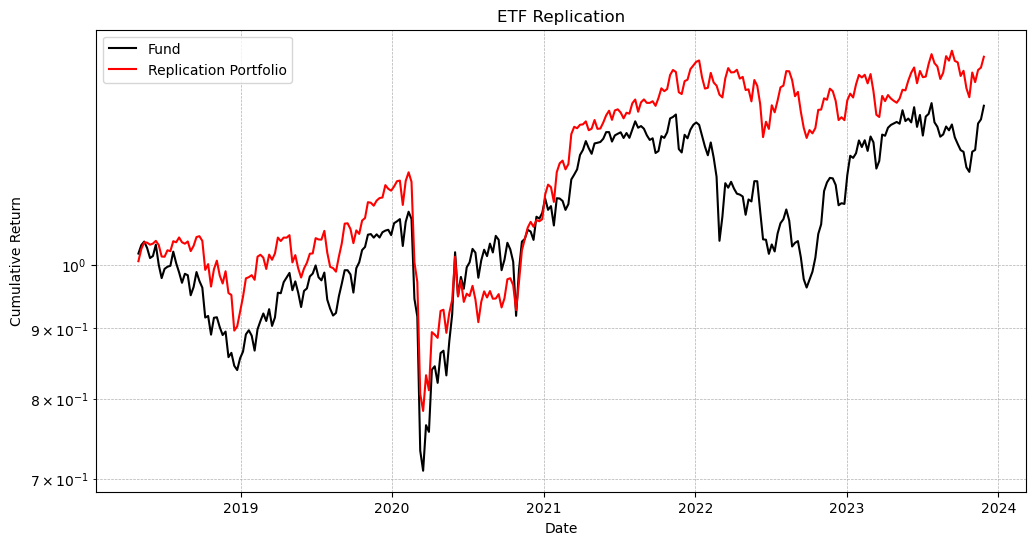

In [4]:
# data sourcing
start = datetime(1900, 3, 1)
end = datetime(2023, 12, 2)

data = yf.download(assets + [target], start=start, end=end, interval='1wk')['Adj Close']

# returns
returns = data.pct_change().dropna()

# Replication
X = returns[assets]
y = returns[target]
coeffs = weight_optimization(X, y, loss = 'te')

# Coefficients
cash_coeff = 1 - sum(coeffs)
print("Coefficients / Weights:")
for asset, coeff in zip(assets, coeffs):
    print(f"{asset}: {coeff:.2f}")
print(f"Cash: {cash_coeff:.2f}")

# replication returns
replicated_returns = X.dot(coeffs)

# tracking error
tracking_error = np.std(replicated_returns - y)

# r & R^2
correlation_matrix = np.corrcoef(replicated_returns, y)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(f"Correlation: {correlation_xy:.2f}")
print(f"R^2: {r_squared:.2f}")
print(f"Tracking Error: {tracking_error:.2f}")

#Plot
plt.figure(figsize=(12, 6))
plt.plot((1 + returns[target]).cumprod(), label='Fund', color = 'black')
plt.plot((1 + replicated_returns).cumprod(), label='Replication Portfolio', color = 'red')
plt.title('ETF Replication')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.yscale('log')
plt.legend()
plt.show()

## Sharpe Ratio Test

In [14]:
def sharpe_ratio_bootstrap_test(sample1, sample2, n_permutations=1000000):
    
    # Bootstrap sampling from Benchmark and compute Sharpe ratios
    sharpe_ratios = []
    n = len(sample1)
    for _ in range(n_permutations):
        bootstrap_sample = np.random.choice(sample1, size=n, replace=True)
        mean_return = np.mean(bootstrap_sample)
        std_return = np.std(bootstrap_sample)
        sharpe_ratio = mean_return / std_return
        sharpe_ratios.append(sharpe_ratio)

    # Observed Sharpe ratio
    observed_mean_return = np.mean(sample2)
    observed_std_return = np.std(sample2)
    observed_sharpe_ratio = observed_mean_return / observed_std_return

    # Benchmark Sharpe ratio
    benchmark_mean_return = np.mean(sample1)
    benchmark_std_return = np.std(sample1)
    benchmark_sharpe_ratio = benchmark_mean_return / benchmark_std_return    

    # p-value (right-sided alternative hypothesis)
    p_value = (np.array(sharpe_ratios) >= observed_sharpe_ratio).mean()
    
    print(f"p-value: {p_value*100:.2f}%")

    # Plot
    plt.figure(figsize=(11, 6), dpi=100)
    plt.hist(sharpe_ratios, bins=100, color='black')
    plt.axvline(observed_sharpe_ratio, color='red', linestyle='dashed', linewidth=2,
                label=f'Fund Sharpe Ratio: {observed_sharpe_ratio:.2f}')
    plt.axvline(benchmark_sharpe_ratio, color='blue', linestyle='dashed', linewidth=2,
                label=f'Replication Portfolio Sharpe Ratio: {benchmark_sharpe_ratio:.2f}')
    plt.legend()
    plt.xlabel('Sharpe Ratio')
    plt.ylabel('frequency')
    plt.title('Null Distribution of Replication Portfolio Sharpe Ratios')
    plt.show()

p-value: 60.80%


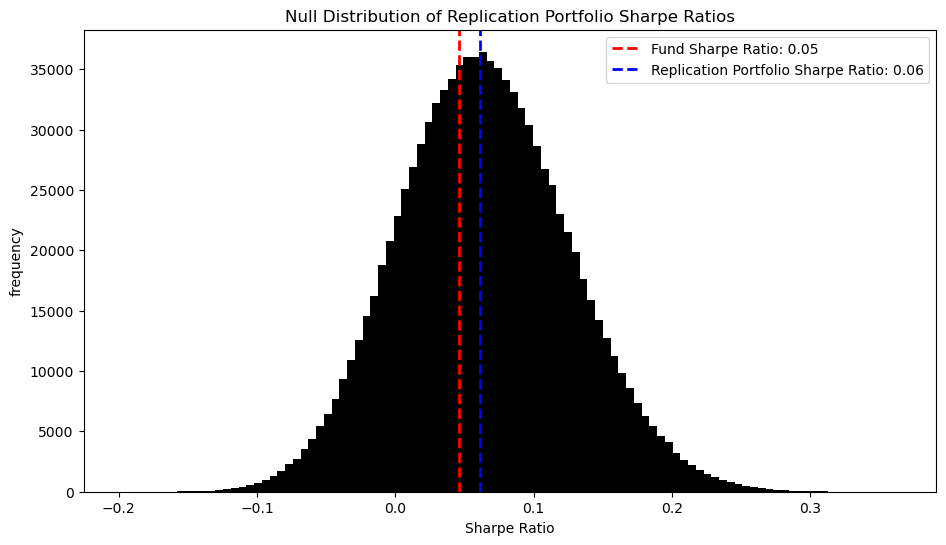

In [15]:
sharpe_ratio_bootstrap_test(replicated_returns, y)

## Fund's Alpha

In [18]:
# variables
X = replicated_returns
Y = y
X = sm.add_constant(X) # intercept

# regression
model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 ^GDAXI   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     981.4
Date:                Fri, 08 Dec 2023   Prob (F-statistic):           4.49e-95
Time:                        09:56:40   Log-Likelihood:                 834.07
No. Observations:                 292   AIC:                            -1664.
Df Residuals:                     290   BIC:                            -1657.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.274      0.7